In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import re
import glob

# Set global rcParams for font type
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


In [3]:
print(matplotlib.__version__)
print(sns.__version__)

3.4.3
0.12.2


In [4]:
import sys
print(sys.version)

3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]


======== {'Promatch || AG': [2.903992533333333e-13], 'Promatch': [], 'AstreaG': [], 'Smith': []}
======== {'Promatch || AG': [2.903992533333333e-13], 'Promatch': [5.899049666666667e-13], 'AstreaG': [], 'Smith': []}
======== {'Promatch || AG': [2.903992533333333e-13], 'Promatch': [5.899049666666667e-13], 'AstreaG': [4.207781e-13], 'Smith': []}
======== {'Promatch || AG': [2.903992533333333e-13], 'Promatch': [5.899049666666667e-13], 'AstreaG': [4.207781e-13], 'Smith': [4.4387466666666666e-11]}
======== {'Promatch || AG': [2.903992533333333e-13, 5.334632666666667e-12], 'Promatch': [5.899049666666667e-13], 'AstreaG': [4.207781e-13], 'Smith': [4.4387466666666666e-11]}
======== {'Promatch || AG': [2.903992533333333e-13, 5.334632666666667e-12], 'Promatch': [5.899049666666667e-13, 2.89903e-11], 'AstreaG': [4.207781e-13], 'Smith': [4.4387466666666666e-11]}
======== {'Promatch || AG': [2.903992533333333e-13, 5.334632666666667e-12], 'Promatch': [5.899049666666667e-13, 2.89903e-11], 'AstreaG': [4.

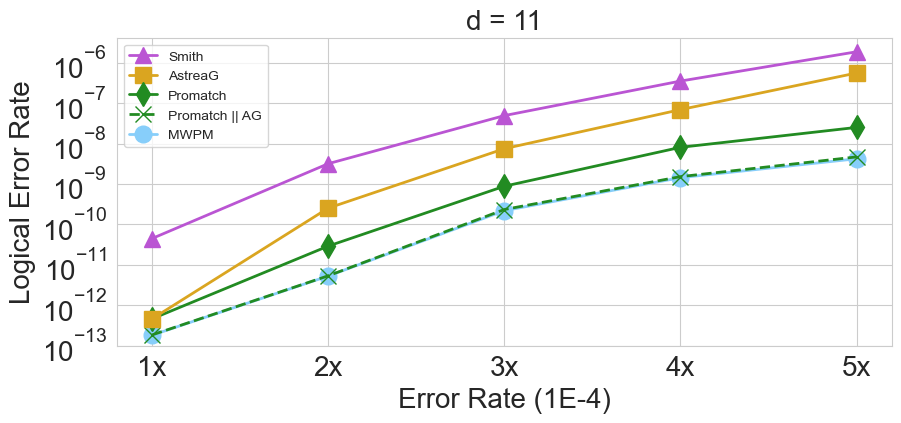

In [203]:
# Define the base directory and file structure
avg_data = {}
s =20
base_dir = "../revision_results/PER_d11/Predecoders/"
error_rates = ['1x', '2x', '3x', '4x', '5x']
x_values = range(len(error_rates))
files_per_rate = 3
# decoders = ['Promatch', 'Promatch || AG', 'AstreaG', 'Clique || AG', 'Smith', 'Smith || AG']
decoders = ['Promatch || AG', 'Promatch', 'AstreaG', 'Smith']

# Construct the file paths
file_paths = {rate: glob.glob(f"{base_dir}{rate}/predecoders_d11_r*_Multi_Astrea_{rate}p.txt") for rate in error_rates}


def extract_data(filepath, decoders):
    data = {decoder: None for decoder in decoders}
    with open(filepath, 'r') as file:
        lines = file.readlines()

        # Create a flag to identify when a decoder block is being read
        current_decoder = None
        for line in lines:
            # Check if the line is a decoder header
            for decoder in decoders:
                if line.strip().startswith(f"===== {decoder} ====="):
                    current_decoder = decoder
                    break

            # If within a decoder block and a "Logical error rate" line is found
            if current_decoder and "Logical error rate =" in line:
                ler_match = re.search(r"(\d+(\.\d+)?(e[+-]?\d+)?)", line)
                if ler_match:
                    data[current_decoder] = float(ler_match.group(1))
                    current_decoder = None  # Reset for the next block

    return data



# Process the files and calculate the averages
avg_data = {decoder: [] for decoder in decoders}
for rate in error_rates:
    rate_data = {decoder: [] for decoder in decoders}
    for filepath in file_paths[rate]:
        data = extract_data(filepath, decoders)
#         print("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&", data, filepath)
        for decoder in decoders:
            rate_data[decoder].append(data[decoder])
    for decoder in decoders:
        avg_data[decoder].append(sum(rate_data[decoder]) / len(rate_data[decoder]))
        print("========", avg_data)

# MWPM file paths
mwpm_base_dir = "../revision_results/PER_d11/"
mwpm_file_paths = {}
mwpm_file_paths = {rate: glob.glob(f"{mwpm_base_dir}{rate}/MWPM_d11_r*_{rate}p.txt") for rate in error_rates}

def extract_mwpm_data(filepath):
    last_ler = 0  # Default value
    with open(filepath, 'r') as file:
        lines = file.readlines()
        for line in lines:
            if "Logical error rate =" in line:
                ler_match = re.search(r"(\d+(\.\d+)?(e[+-]?\d+)?)", line)
                if ler_match:
                    last_ler = float(ler_match.group(1))
    return last_ler

# Process MWPM files and calculate the averages
mwpm_avg_data = []
for rate in error_rates:
    ler_values = []
#     print(mwpm_file_paths)
    for filepath in mwpm_file_paths[rate]:
        ler = extract_mwpm_data(filepath)
        print(ler, filepath)
        if ler is not None:
            ler_values.append(ler)

    if ler_values:
        average_ler = sum(ler_values) / len(ler_values)
    else:
        average_ler = None
    mwpm_avg_data.append(average_ler)

# # Plotting
# Define colors and styles
# Define colors and styles
color_map = {}
style_map = {}
base_color = ['forestgreen', 'orange' , 'mediumorchid', 'darkgoldenrod', 'm', 'y', 'orange']  # Extended color set to ensure uniqueness
color_idx = 0

for decoder in decoders:

    if "|| AG" in decoder:
        # Special case for "Clique || AG"
        if decoder == "Clique || AG":
            color_map[decoder] = 'darkturquoise'  # Assign a unique color for "Clique || AG"
        else:
            base_decoder = decoder.split(' || ')[0]
            color_map[decoder] = color_map.get(base_decoder, base_color[color_idx])

        style_map[decoder] = {'linestyle': '--', 'marker': 'x'}
    else:
        if "AstreaG" in decoder :
            style_map[decoder] = {'linestyle': '-', 'marker': 's'}
        if "Promatch" in decoder :
            style_map[decoder] = {'linestyle': '-', 'marker': 'd'}
        if "Smith" in decoder :
            style_map[decoder] = {'linestyle': '-', 'marker': '^'}
        if "Clique" in decoder :
            style_map[decoder] = {'linestyle': '-', 'marker': 'p'}
        if decoder not in color_map:
            color_map[decoder] = base_color[color_idx]
            color_idx = (color_idx + 1) % len(base_color)
            if decoder == "AstreaG":
                color_map[decoder] = 'goldenrod'  # Assign a unique color for "Clique || AG"



mwpm_avg_data[0] = 1.80954369068631E-13
avg_data["Promatch"][0] = 4.59757509067524E-13
avg_data["Promatch || AG"][0] = 1.83605140990578E-13
avg_data["AstreaG"][0] = 4.59558777606565E-13
# avg_data["Clique || AG"][0] = 4.59558777606565E-13
avg_data["Smith"][0] = 4.46598031558078E-11
# avg_data["Smith || AG"][0] = 2.45500587990828E-13


# Set Seaborn style
sns.set_style("whitegrid")
plt.figure(figsize=(10, 4))
plt.plot(x_values, mwpm_avg_data, label='MWPM', color='lightskyblue', marker='o', linestyle='-', linewidth=2,
                 markersize=12)

for decoder in decoders:
    plot_x = [x for x, y in zip(x_values, avg_data[decoder]) if y is not None]
    plot_y = [y for y in avg_data[decoder] if y is not None]

    if plot_y:
        # Adjust marker edge width if the marker is 'x'
        if style_map[decoder]['marker'] == 'x':
            markeredgewidth = 10  # Increase edge width for better visibility
        else:
            markeredgewidth = 1  # Default edge width for other markers

        plt.plot(plot_x, plot_y, label=decoder,
                 color=color_map[decoder],
                 linestyle=style_map[decoder]['linestyle'],
                 marker=style_map[decoder]['marker'],
                 linewidth=2,
                 markersize=12)

handles, labels = plt.gca().get_legend_handles_labels()

# Reverse the order
handles.reverse()
labels.reverse()
# Add labels and title
plt.xticks(x_values, error_rates)
plt.xlabel('Error Rate (1E-4)', fontsize = s)
plt.ylabel('Logical Error Rate', fontsize = s)
plt.title('d = 11',fontsize = s)
plt.yscale('log')
plt.ylim([1e-13, None])  # Set the lower bound to 10^-13
plt.xticks(fontsize=s)  # Adjust the font size for x-axis tick labels
plt.yticks(fontsize=s) 
plt.legend(handles, labels, fontsize = s*0.5)
plt.savefig('../plots/FinalPlots/sensitivity_analysis_d_11.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [172]:
avg_data["Clique || AG"]

[4.59558777606565e-13,
 2.5234433333333333e-10,
 7.452366666666667e-09,
 6.907483333333333e-08,
 5.565413333333333e-07]

In [173]:
avg_data

{'Promatch': [4.59757509067524e-13,
  2.89903e-11,
  8.782223333333333e-10,
  8.06359e-09,
  2.509063333333333e-08],
 'Promatch || AG': [1.83605140990578e-13,
  5.334632666666667e-12,
  2.3316366666666666e-10,
  1.517458e-09,
  4.668753333333333e-09],
 'AstreaG': [4.59558777606565e-13,
  2.5234433333333333e-10,
  7.452366666666667e-09,
  6.907483333333333e-08,
  5.565413333333333e-07],
 'Clique || AG': [4.59558777606565e-13,
  2.5234433333333333e-10,
  7.452366666666667e-09,
  6.907483333333333e-08,
  5.565413333333333e-07],
 'Smith': [4.46598031558078e-11,
  3.1715866666666665e-09,
  4.9141033333333336e-08,
  3.515486666666667e-07,
  1.8663533333333334e-06],
 'Smith || AG': [2.45500587990828e-13,
  3.567686666666667e-11,
  1.081952e-09,
  1.0117113333333334e-08,
  1.051355e-07]}

In [174]:
mwpm_avg_data

[1.80954369068631e-13,
 5.262366733333333e-12,
 2.1839233333333332e-10,
 1.4316266666666664e-09,
 4.200113333333333e-09]

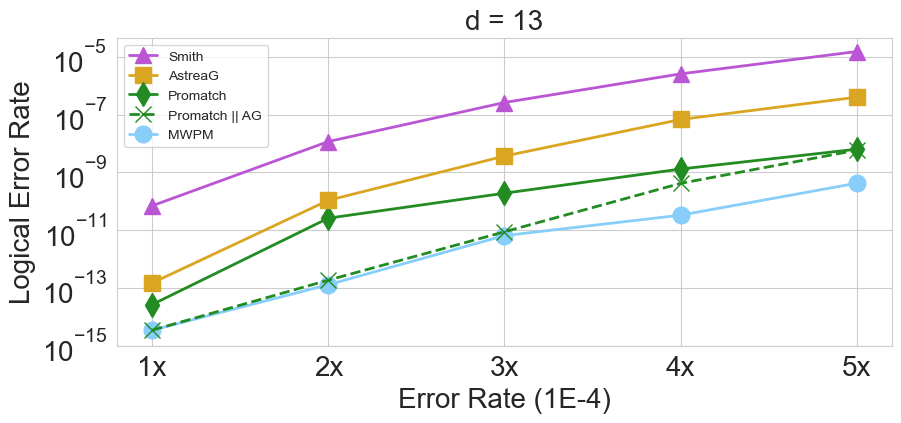

In [204]:
# Define the base directory and file structure
avg_data = {}
s =20

base_dir = "../revision_results/PER_d13/Predecoders/"
error_rates = ['1x', '2x', '3x', '4x', '5x']
x_values = range(len(error_rates))
files_per_rate = 3
# decoders = ['Promatch', 'Promatch || AG', 'AstreaG', 'Clique || AG', 'Smith', 'Smith || AG']
decoders = ['Promatch || AG','Promatch', 'AstreaG', 'Smith']

# Construct the file paths
file_paths = {rate: glob.glob(f"{base_dir}{rate}/predecoders_d13_r*_Multi_Astrea_{rate}p.txt") for rate in error_rates}


def extract_data(filepath, decoders):
    data = {decoder: None for decoder in decoders}
    with open(filepath, 'r') as file:
        lines = file.readlines()

        # Create a flag to identify when a decoder block is being read
        current_decoder = None
        for line in lines:
            # Check if the line is a decoder header
            for decoder in decoders:
                if line.strip().startswith(f"===== {decoder} ====="):
                    current_decoder = decoder
                    break

            # If within a decoder block and a "Logical error rate" line is found
            if current_decoder and "Logical error rate =" in line:
                ler_match = re.search(r"(\d+(\.\d+)?(e[+-]?\d+)?)", line)
                if ler_match:
                    data[current_decoder] = float(ler_match.group(1))
                    current_decoder = None  # Reset for the next block

    return data



# Process the files and calculate the averages
avg_data = {decoder: [] for decoder in decoders}
for rate in error_rates:
    rate_data = {decoder: [] for decoder in decoders}
    for filepath in file_paths[rate]:
        data = extract_data(filepath, decoders)
#         print("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&", data, filepath)
        for decoder in decoders:
            rate_data[decoder].append(data[decoder])
    for decoder in decoders:
        avg_data[decoder].append(sum(rate_data[decoder]) / len(rate_data[decoder]))
#         print("========", avg_data)

# MWPM file paths
mwpm_base_dir = "../revision_results/PER_d13/"
mwpm_file_paths = {rate: glob.glob(f"{mwpm_base_dir}{rate}/MWPM_d13_r*_{rate}p.txt") for rate in error_rates}


def extract_mwpm_data(filepath):
    last_ler = 0  # Default value
    with open(filepath, 'r') as file:
        lines = file.readlines()
        for line in lines:
            if "Logical error rate =" in line:
                ler_match = re.search(r"(\d+(\.\d+)?(e[+-]?\d+)?)", line)
                if ler_match:
                    last_ler = float(ler_match.group(1))
    return last_ler

# Process MWPM files and calculate the averages
mwpm_avg_data = []
for rate in error_rates:
    ler_values = []
#     print(mwpm_file_paths)
    for filepath in mwpm_file_paths[rate]:
        ler = extract_mwpm_data(filepath)
#         print(ler, filepath)
        if ler is not None:
            ler_values.append(ler)

    if ler_values:
        average_ler = sum(ler_values) / len(ler_values)
    else:
        average_ler = None
    mwpm_avg_data.append(average_ler)

# # Plotting
# Define colors and styles
# Define colors and styles
color_map = {}
style_map = {}
base_color = ['forestgreen', 'orange' , 'mediumorchid', 'darkgoldenrod', 'm', 'y', 'orange']  # Extended color set to ensure uniqueness
color_idx = 0

for decoder in decoders:

    if "|| AG" in decoder:
        # Special case for "Clique || AG"
        if decoder == "Clique || AG":
            color_map[decoder] = 'darkturquoise'  # Assign a unique color for "Clique || AG"
        else:
            base_decoder = decoder.split(' || ')[0]
            color_map[decoder] = color_map.get(base_decoder, base_color[color_idx])

        style_map[decoder] = {'linestyle': '--', 'marker': 'x'}
    else:
        if "AstreaG" in decoder :
            style_map[decoder] = {'linestyle': '-', 'marker': 's'}
        if "Promatch" in decoder :
            style_map[decoder] = {'linestyle': '-', 'marker': 'd'}
        if "Smith" in decoder :
            style_map[decoder] = {'linestyle': '-', 'marker': '^'}
        if "Clique" in decoder :
            style_map[decoder] = {'linestyle': '-', 'marker': 'p'}
        if decoder not in color_map:
            color_map[decoder] = base_color[color_idx]
            color_idx = (color_idx + 1) % len(base_color)
            if decoder == "AstreaG":
                color_map[decoder] = 'goldenrod'  # Assign a unique color for "Clique || AG"


# Set Seaborn style
sns.set_style("whitegrid")
plt.figure(figsize=(10, 4))
plt.plot(x_values, mwpm_avg_data, label='MWPM', color='lightskyblue', marker='o', linestyle='-', linewidth=2,
                 markersize=12)
for decoder in decoders:
    plot_x = [x for x, y in zip(x_values, avg_data[decoder]) if y is not None]
    plot_y = [y for y in avg_data[decoder] if y is not None]

    if plot_y:
        # Adjust marker edge width if the marker is 'x'
        if style_map[decoder]['marker'] == 'x':
            markeredgewidth = 10  # Increase edge width for better visibility
        else:
            markeredgewidth = 1  # Default edge width for other markers

        plt.plot(plot_x, plot_y, label=decoder,
                 color=color_map[decoder],
                 linestyle=style_map[decoder]['linestyle'],
                 marker=style_map[decoder]['marker'],
                 linewidth=2,
                 markersize=12)

handles, labels = plt.gca().get_legend_handles_labels()

# Reverse the order
handles.reverse()
labels.reverse()

# Add labels and title
plt.xticks(x_values, error_rates)
plt.xlabel('Error Rate (1E-4)', fontsize = s)
plt.ylabel('Logical Error Rate', fontsize = s)
plt.title('d = 13',fontsize = s)
plt.yscale('log')
plt.ylim([1e-15, None])  # Set the lower bound to 10^-13
plt.xticks(fontsize=s)  # Adjust the font size for x-axis tick labels
plt.yticks(fontsize=s) 
plt.legend(handles, labels, fontsize = s*0.5)
plt.savefig('../plots/FinalPlots/sensitivity_analysis_d_13.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [197]:
avg_data

{'Promatch': [2.6441833333333333e-14,
  2.5980420000000004e-11,
  1.9021620000000002e-10,
  1.3097866666666666e-09,
  6.376126666666666e-09],
 'Promatch || AG': [3.4222831589999996e-15,
  1.851494625e-13,
  8.745723333333334e-12,
  4.1698433333333334e-10,
  5.8893e-09],
 'AstreaG': [1.4806866666666665e-13,
  1.077363375e-10,
  3.6755566666666668e-09,
  6.81746e-08,
  4.049106666666667e-07],
 'Smith': [6.981493333333333e-11,
  1.1733099999999999e-08,
  2.639476666666667e-07,
  2.597536666666667e-06,
  1.54171e-05]}

In [198]:
mwpm_avg_data

[3.420133989e-15,
 1.2860007212533333e-13,
 6.450471325833333e-12,
 3.302353553333334e-11,
 4.2344126666666666e-10]

In [199]:
# Data for 'Promatch' and 'MWPM'
promatch_data = avg_data['Promatch']
mwpm_data = mwpm_avg_data

# Calculate the ratio and find the maximum
ratios = []
for promatch_value, mwpm_value in zip(promatch_data, mwpm_data):
    if mwpm_value != 0:
        
        ratio = promatch_value / mwpm_value
        print(promatch_value,mwpm_value, ratio)
        ratios.append(ratio)
    else:
        ratios.append(float('inf'))  # Handle division by zero, if any

max_ratio = max(ratios)

# Print the maximum ratio
print("The maximum ratio of 'Promatch' to 'MWPM' is:", max_ratio)


2.6441833333333333e-14 3.420133989e-15 7.731227319858472
2.5980420000000004e-11 1.2860007212533333e-13 202.02492557453272
1.9021620000000002e-10 6.450471325833333e-12 29.488728868262367
1.3097866666666666e-09 3.302353553333334e-11 39.66221803672694
6.376126666666666e-09 4.2344126666666666e-10 15.057877369533657
The maximum ratio of 'Promatch' to 'MWPM' is: 202.02492557453272


In [153]:
avg_data['AstreaG'][0]/avg_data['Promatch'][0]

5.599788214382512

In [156]:
# Data for 'Promatch' and 'MWPM'
promatch_data = avg_data['AstreaG']
mwpm_data = avg_data['Promatch']

# Calculate the ratio and find the maximum
ratios = []
for promatch_value, mwpm_value in zip(promatch_data, mwpm_data):
    if mwpm_value != 0:
        
        ratio = promatch_value / mwpm_value
        print(promatch_value,mwpm_value, ratio)
        ratios.append(ratio)
    else:
        ratios.append(float('inf'))  # Handle division by zero, if any

max_ratio = max(ratios)

# Print the maximum ratio
print("The maximum ratio of 'AstreaG' to 'MWPM' is:", max_ratio)

4.59558777606565e-13 4.59757509067524e-13 0.9995677472210033
2.5234433333333333e-10 2.89903e-11 8.70444022080949
7.452366666666667e-09 8.782223333333333e-10 8.485740323160385
6.907483333333333e-08 8.06359e-09 8.566263082985783
5.565413333333333e-07 2.509063333333333e-08 22.18123894839907
The maximum ratio of 'AstreaG' to 'MWPM' is: 22.18123894839907


In [161]:
# Data for 'Promatch' and 'MWPM'
promatch_data = avg_data['AstreaG']
mwpm_data = mwpm_avg_data

# Calculate the ratio and find the maximum
ratios = []
for promatch_value, mwpm_value in zip(promatch_data, mwpm_data):
    if mwpm_value != 0:
        
        ratio = promatch_value / mwpm_value
        print(promatch_value,mwpm_value, ratio)
        ratios.append(ratio)
    else:
        ratios.append(float('inf'))  # Handle division by zero, if any

max_ratio = max(ratios)

# Print the maximum ratio
print("The maximum ratio of 'AstreaG' to 'MWPM' is:", max_ratio)

1.4806866666666665e-13 3.420133989e-15 43.29323562845556
9.710798333333333e-11 1.2860007212533333e-13 755.1160876386766
3.6755566666666668e-09 6.450471325833333e-12 569.8121084495828
6.81746e-08 3.302353553333334e-11 2064.4246262241013
4.049106666666667e-07 4.2344126666666666e-10 956.2380866988401
The maximum ratio of 'AstreaG' to 'MWPM' is: 2064.4246262241013


In [200]:
# Data for 'Promatch' and 'MWPM'
promatch_data = avg_data['Promatch || AG']
mwpm_data = mwpm_avg_data

# Calculate the ratio and find the maximum
ratios = []
for promatch_value, mwpm_value in zip(promatch_data, mwpm_data):
    if mwpm_value != 0:
        
        ratio = promatch_value / mwpm_value
        print(promatch_value,mwpm_value, ratio)
        ratios.append(ratio)
    else:
        ratios.append(float('inf'))  # Handle division by zero, if any

max_ratio = max(ratios)

# Print the maximum ratio
print("The maximum ratio of 'Promatch || AG' to 'MWPM' is:", max_ratio)

3.4222831589999996e-15 3.420133989e-15 1.0006283876616857
1.851494625e-13 1.2860007212533333e-13 1.4397306272079984
8.745723333333334e-12 6.450471325833333e-12 1.3558270227956526
4.1698433333333334e-10 3.302353553333334e-11 12.626883421141784
5.8893e-09 4.2344126666666666e-10 13.908186243538854
The maximum ratio of 'Promatch || AG' to 'MWPM' is: 13.908186243538854


In [166]:
# Data for 'Promatch' and 'MWPM'
promatch_data = avg_data['Smith || AG']
mwpm_data = mwpm_avg_data

# Calculate the ratio and find the maximum
ratios = []
for promatch_value, mwpm_value in zip(promatch_data, mwpm_data):
    if mwpm_value != 0:
        
        ratio = promatch_value / mwpm_value
        print(promatch_value,mwpm_value, ratio)
        ratios.append(ratio)
    else:
        ratios.append(float('inf'))  # Handle division by zero, if any

max_ratio = max(ratios)

# Print the maximum ratio
print("The maximum ratio of 'Promatch || AG' to 'MWPM' is:", max_ratio)

1.5468630666666666e-14 3.420133989e-15 4.522814227868739
8.36505125e-12 1.2860007212533333e-13 65.04701833951883
2.361159e-10 6.450471325833333e-12 36.604441454438415
5.040813333333333e-09 3.302353553333334e-11 152.64305447383825
3.7242e-08 4.2344126666666666e-10 87.95080435397651
The maximum ratio of 'Promatch || AG' to 'MWPM' is: 152.64305447383825


In [121]:
# Data for 'Promatch' and 'MWPM'
promatch_data = avg_data['Smith']
mwpm_data = mwpm_avg_data

# Calculate the ratio and find the maximum
ratios = []
for promatch_value, mwpm_value in zip(promatch_data, mwpm_data):
    if mwpm_value != 0:
        
        ratio = promatch_value / mwpm_value
        print(promatch_value,mwpm_value, ratio)
        ratios.append(ratio)
    else:
        ratios.append(float('inf'))  # Handle division by zero, if any

max_ratio = max(ratios)

# Print the maximum ratio
print("The maximum ratio of 'Promatch || AG' to 'MWPM' is:", max_ratio)

6.981493333333333e-11 3.420133989e-15 20412.923457933368
1.1659875e-08 4.3796389800000005e-15 2662291.356261515
2.639476666666667e-07 6.450471325833333e-12 40919.12874793958
2.597536666666667e-06 3.302353553333334e-11 78657.1342140142
1.54171e-05 4.2344126666666666e-10 36409.06357890799
The maximum ratio of 'Promatch || AG' to 'MWPM' is: 2662291.356261515


In [113]:
# Specify the file path
file_path = '../promatch_mistakes_d11_all.txt'  # Replace with your file path

# Read the file and filter out lines with asterisks
with open(file_path, 'r') as file:
    lines = file.readlines()
    filtered_lines = [line for line in lines if '*' not in line]

# Write the filtered lines back to the file
with open(file_path, 'w') as file:
    file.writelines(filtered_lines)

print("File processed and saved.")


File processed and saved.


In [68]:
def remove_common_lines(file1, file2):
    # Read file2 and store its lines in a set
    with open(file2, 'r') as f2:
        lines_in_file2 = set(f2.readlines())

    # Read file1 and filter out lines that are in file2
    with open(file1, 'r') as f1:
        filtered_lines = [line for line in f1 if line not in lines_in_file2]

    # Write the filtered lines back to file1 (or to a new file if preferred)
    with open(file1, 'w') as f1:
        f1.writelines(filtered_lines)

    print("File processed and saved.")

# Example usage
file1_path = '../promatch_mistakes_d11_all.txt'  # Replace with your file1 path
file2_path = '../mwpm_mistakes_d11_all.txt'  # Replace with your file2 path
remove_common_lines(file1_path, file2_path)


File processed and saved.
